<a href="https://colab.research.google.com/github/mollah2022/Neural-Network/blob/main/Fraud_Detection_Neural_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [5]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard.csv")
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

In [16]:
df.shape

(284807, 31)

In [6]:
# Normalize Amount
X['Amount'] = StandardScaler().fit_transform(X[['Amount']])

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
# Class weights to handle imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

In [9]:
# Model definition
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(29,)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:

# Train
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=30,
          batch_size=2048,
          class_weight=class_weights,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8014 - loss: 1.3711 - val_accuracy: 0.9332 - val_loss: 0.5087
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8140 - loss: 0.3710 - val_accuracy: 0.9632 - val_loss: 0.3649
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8400 - loss: 0.3262 - val_accuracy: 0.9670 - val_loss: 0.2786
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8600 - loss: 0.3324 - val_accuracy: 0.9627 - val_loss: 0.2359
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8765 - loss: 0.2785 - val_accuracy: 0.9682 - val_loss: 0.2031
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8986 - loss: 0.2340 - val_accuracy: 0.9746 - val_loss: 0.1778
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9103 - loss: 0.2950 - val_accuracy: 0.9744 - val_loss: 0.1624
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9206 - loss: 0.2251 - val_accuracy: 0.9771 - 

In [11]:
# Prediction probabilities
y_scores = model.predict(X_test).ravel()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [12]:
# Find best threshold for F1
prec, rec, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * prec * rec / (prec + rec)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold for F1: {best_thresh:.3f}")


Best Threshold for F1: 1.000


In [13]:
# Final predictions
y_pred = (y_scores > best_thresh).astype(int)

In [14]:
# Final Evaluation
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_scores))


Confusion Matrix:
 [[56846    18]
 [   18    80]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8163    0.8163    0.8163        98

    accuracy                         0.9994     56962
   macro avg     0.9080    0.9080    0.9080     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC AUC Score: 0.9800113841259632


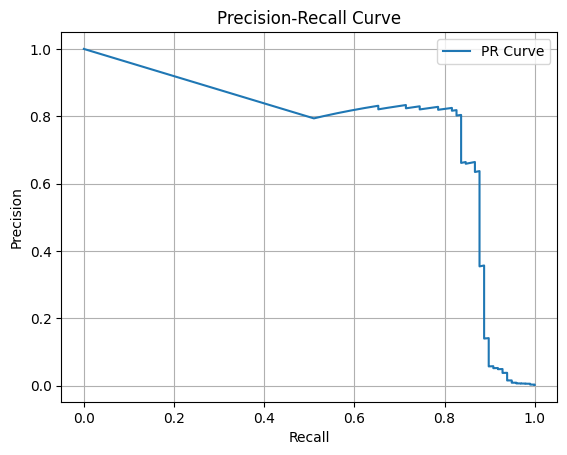

In [15]:
# Plot PR curve
plt.plot(rec, prec, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()